## Exemple de script python qui réalise un traitement statistique simple à partir d'un service SensorThings

**Dans cet exemple, on souhaite représenter l'évolution de l'humidité moyenne des parcelles cultivées du bassin versant de Naizin/Kervidy dans le Morbihan de 2017 à 2022.**

+ Le script réalise d'abord une intersection spatiale entre le contour du bassin versant et les parcelles présentes dans le service SensorThings BOSCO.
+ Il télécharge ensuite les séries temporelles de l'humidité de surface pour les parcelles concernées.
+ Enfin, il affiche un graphique réprésentant l'évolution de la moyenne de cette humidé pour l'ensemble du bassin versant de Kervidy.

In [1]:
import requests
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import geopandas as gpd
from tqdm import tqdm
import shapely.geometry
import datetime

In [2]:
class telechargement_geo_spatial():
    """Méthode de télécharment des observations d'une ObservedProperty par intersection spatiale et filtre temporel

    Attributes:
        url_service (string): url du service sensorthing
        geom (geometry): geometry pour réaliser l'intersection
        obsP (string): observedProperty ciblée
        date_start (string): date de début d'observation
        date_end (string): date de fin d'observation
    """
    def __init__(self, url_service, geom,  obsP, date_start, date_end):
        self.url_service = url_service
        self.geom = geom
        self.obsP = obsP
        self.date_start = date_start
        self.date_end = date_end

        if self.geom.geom_type == 'MultiPolygon':
            print("MultipolygonE, conversion en polygone")
            self.geom =self.geom.geoms[0]

    def get_data(self,url_requete):
        """Télécharge les données d'une requête sensorthing avec itération dans les pages

        Args:
            url_requete (str): url à télécharger
        Returns:
            dataframe: dataframe (pandas) des données téléchargées
        """
        r=requests.get(url=url_requete)
        if r.status_code not in [200, 201, 202]:
            print(r.status_code)
            if r.status_code == 414:
                print("url trop grande = la géometrie en entrée est trop complexe \n \
                tentative d'intersection par la bounding box")

                self.geom=shapely.geometry.box(*self.geom.bounds, ccw=True)
                url_requete=self.inter_geo_temporelle()
                print(url_requete)
                r=requests.get(url=url_requete)

        data=r.json()
        df_all=pd.DataFrame(data['value'])
        while '@iot.nextLink' in data:
            r=requests.get(url=data['@iot.nextLink'])
            data=r.json()
            df_all=pd.concat([df_all,pd.DataFrame(data['value'])])
        return df_all

    def inter_geo_temporelle(self):
        """Façonne l'url de requête selon les différents arguments de la classe
        Returns:
            string: url avec les filtres
        """
        objet='Datastreams'
        rqt=f"$filter=geo.intersects(Thing/Locations/location, geography'{self.geom}') \
    and ObservedProperty/name eq'{self.obsP}'\
&$select=name,description,unitOfMeasurement,Observations,phenomenonTime\
&$expand=Thing/Locations($select=name,@iot.id,location)"
        url_rqt=f"{self.url_service}{objet}?{rqt}"
        print("Requête générée:\n")
        #print(url_rqt)
        return url_rqt

    def get_all(self,df):
        """Télécharge les observations des datastreams
        Args:
            df (dataframe): dataframe des datastreams avec une colonne contenant les lien vers les observations
        Returns:
            dataframe: dataframe des données téléchargées pour tous les datastreams avec les coordonnées géographiques de chaque observations
        """
        df_data=pd.DataFrame()
        print("\nTéléchargement en cours : \n")
        for idx,row in tqdm(df.iterrows(), total=df.shape[0]):
            #print(row['Observations@iot.navigationLink'])
            rqt=row['Observations@iot.navigationLink']
#            rqt+=f"?$select=result,phenomenonTime&$filter=phenomenonTime ge {self.date_start} and phenomenonTime le {self.date_end}"
            rqt+=f"?$select=phenomenonTime,result&$filter=phenomenonTime ge {self.date_start} and phenomenonTime le {self.date_end}"
            df_inter=pd.DataFrame(self.get_data(rqt))
#            df_inter['name']=row['name']
#            df_inter['x']=row['Thing']['Locations'][0]['location']['geometry']['coordinates'][0]
#            df_inter['y']=row['Thing']['Locations'][0]['location']['geometry']['coordinates'][1]
            df_data=pd.concat([df_data,df_inter])
            df_data=df_data.reset_index(drop=True)
        self.unite = row['unitOfMeasurement']['name']
        self.symbol = row['unitOfMeasurement']['symbol']
        return df_data

    def telechargement(self):
        """Fonction qui automatise la classe
        Returns:
            dataframe: dataframe des données téléchargées pour tous les datastreams avec les coordonnées géographiques de chaque observations
        """
        print(f"Recherche des Datastreams par l'ObservedProperty : {self.obsP} par intersection spatial sur la période : {self.date_start} {self.date_end}")
        url_rqt = self.inter_geo_temporelle()
        df_rqt = self.get_data(url_rqt)
        if len(df_rqt) == 0:
            print("\nIl n'y a pas d'objet dans la zone d'intersection, veuillez changer de zone")
            return 0
        else:
            print(f"\nNombre d'objet à téléchargerger :{len(df_rqt)}")
        #faire un retour si pas d'objet
        #refaire la requete si erreur 414 par bounding box
        df = self.get_all(df_rqt)
        df=df.rename(columns={'result':self.obsP})
        return df


### Chargement da la couche géographique du contour du bassin versant 

<AxesSubplot: >

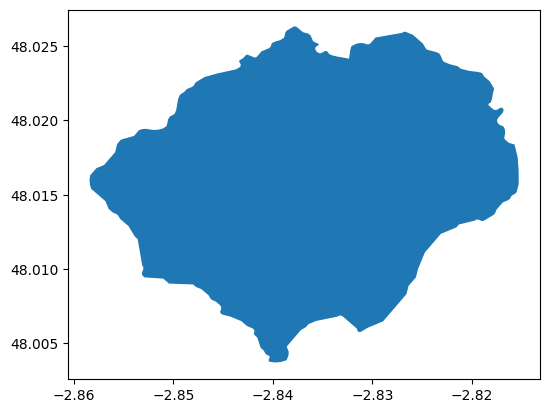

In [3]:
zone=gpd.read_file('/home/squivid/STA/bv_kervidy.geojson')
zone=zone.to_crs('EPSG:4326')
zone.plot()

### Sélection du service et de la proprièté utilisée

In [4]:
url_service='https://frost.geosas.fr/bosco/v1.0/'
obsP="Soil moisture"

### Sélection de la période d'intérêt

In [5]:
date_start, date_end = '2017-01-01T00:00:00Z','2022-12-31T00:00:00Z'

### Téléchargement des séries temporelles

In [6]:
geom=zone.geometry[0]
instance = telechargement_geo_spatial(url_service, geom,  obsP, date_start, date_end)
df = instance.telechargement()
unite = instance.unite
symbol = instance.symbol
display(df)

MultipolygonE, conversion en polygone
Recherche des Datastreams par l'ObservedProperty : Soil moisture par intersection spatial sur la période : 2017-01-01T00:00:00Z 2022-12-31T00:00:00Z
Requête générée:

414
url trop grande = la géometrie en entrée est trop complexe 
                 tentative d'intersection par la bounding box
Requête générée:

https://frost.geosas.fr/bosco/v1.0/Datastreams?$filter=geo.intersects(Thing/Locations/location, geography'POLYGON ((-2.8152714475537 48.00371495105991, -2.8152714475537 48.02631685495629, -2.858427634197667 48.02631685495629, -2.858427634197667 48.00371495105991, -2.8152714475537 48.00371495105991))')     and ObservedProperty/name eq'Soil moisture'&$select=name,description,unitOfMeasurement,Observations,phenomenonTime&$expand=Thing/Locations($select=name,@iot.id,location)

Nombre d'objet à téléchargerger :124

Téléchargement en cours : 



100%|██████████| 124/124 [00:29<00:00,  4.16it/s]


,phenomenonTime,Soil moisture
0,2017-01-03T12:00:00Z,14.2
1,2017-01-04T12:00:00Z,14.8
2,2017-01-05T12:00:00Z,20.6
3,2017-01-06T12:00:00Z,20.4
4,2017-01-09T12:00:00Z,19.4
...,...,...
132226,2022-10-30T12:00:00Z,35.2
132227,2022-11-03T12:00:00Z,37.2
132228,2022-11-06T12:00:00Z,35.8
132229,2022-11-10T12:00:00Z,36.0


### Calcul et affichage de l'évolution de l'humidité moyenne pour l'ensemble du bassin versant 

,Soil moisture
phenomenonTime,
2017-01-03 00:00:00+00:00,17.287379
2017-01-04 00:00:00+00:00,15.136735
2017-01-05 00:00:00+00:00,19.472381
2017-01-06 00:00:00+00:00,20.075472
2017-01-09 00:00:00+00:00,21.788889
...,...
2022-10-30 00:00:00+00:00,30.393548
2022-11-03 00:00:00+00:00,31.909677
2022-11-06 00:00:00+00:00,31.095868


<AxesSubplot: title={'center': 'Humidité moyenne des parcelles de Kervidy'}, xlabel='Date', ylabel='%'>

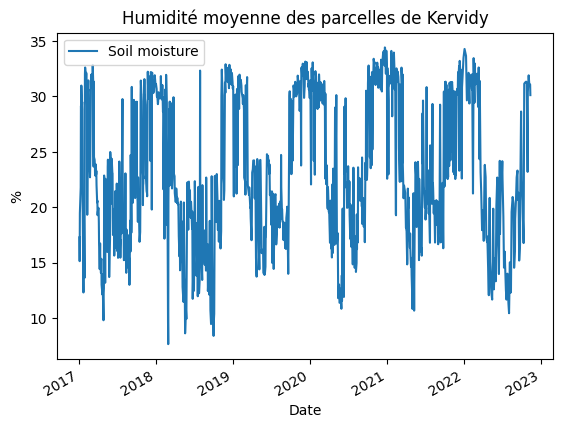

In [7]:
df['phenomenonTime'] = pd.to_datetime(df['phenomenonTime'])
#df = df.set_index("phenomenonTime")
df = df.resample('d', on='phenomenonTime').mean().dropna(how='all')
display (df)
df.plot(title="Humidité moyenne des parcelles de Kervidy", xlabel="Date", ylabel="%")